In [1]:
import rasterio
import numpy as np
import seaborn as sns

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import matplotlib.colors as clr
plt.style.use('seaborn-whitegrid')

In [377]:
%matplotlib notebook

In [323]:
%matplotlib inline

In [3]:
BANDS = [461, 480, 490, 502, 516, 526, 540, 554, 555, 565, 578, 591, 600, 612, 622, # VIS
         671, 680, 707, 720, 733, 744, 758, 770, 783, 795, 815, 825, 836, 847, 857, 867, 877] # NIR

BANDS_L = [461, 480, 490, 502, 516, 526, 540, 554, ' ', 565, 578, 591, 600, 612, 622, # VIS
         671, 680, 707, 720, 733, 744, 758, 770, 783, 795, 815, 825, 836, 847, 857, 867, 877] # NIR

# Unsupervised Classification

In [18]:
src = rasterio.open("../data/pp_2/pp_2_hsi_clipped.tif")

In [19]:
meta = src.meta.copy()

In [20]:
image = src.read()

In [21]:
image = image/65535

In [123]:
ndvi = (image[24]-image[15])/(image[24]+image[15])

/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


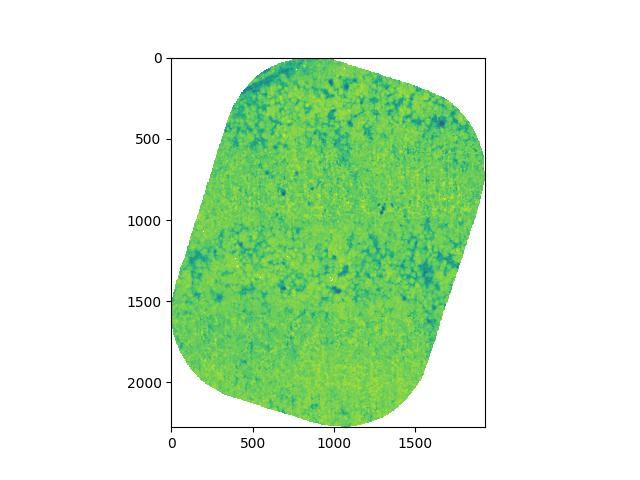

In [37]:
plt.imshow(ndvi)
plt.show()

In [24]:
out_meta = src.meta.copy()
out_meta.update(dtype=rasterio.float64)

In [27]:
with rasterio.open("/Users/vasilii.mosin/Desktop/normalized.tif", 'w', **out_meta) as dst:
    dst.write(normalized)

In [22]:
normalized = image/np.sum(image,axis=0)

/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [64]:
display_image_original = np.stack((image[14],image[10],image[1]),axis=2)
display_image_normalized = np.stack((normalized[14],normalized[10],normalized[1]),axis=2)

<IPython.core.display.Javascript object>


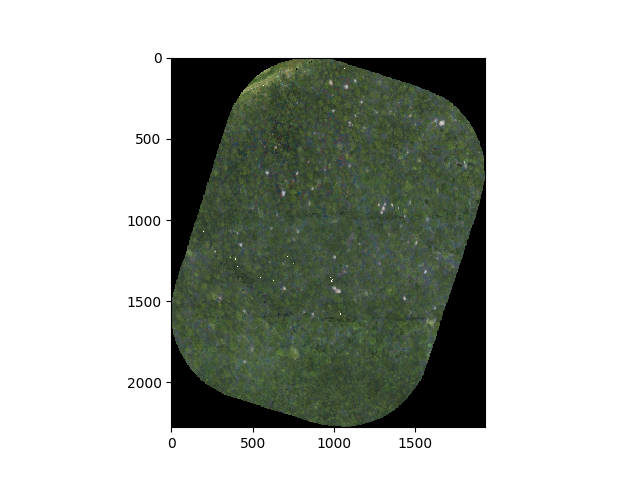

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [79]:
plt.imshow(display_image_normalized*25)
plt.show()

In [125]:
mask = np.ones_like(image[0])

for i in range(32):
    mask[np.where(image[i]==0)] = 0
    
mask[np.where(ndvi<0.5)] = 0

/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


<IPython.core.display.Javascript object>


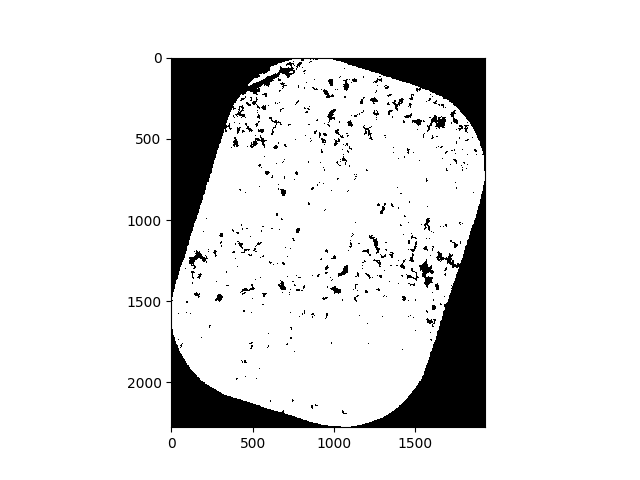

In [83]:
plt.imshow(mask, cmap='gray')
plt.show()

In [29]:
out_meta = src.meta.copy()
out_meta.update(dtype=rasterio.float64, count=1)

In [51]:
with rasterio.open("../data/pp_2/pp_2_mask.tif", 'w', **out_meta) as dst:
    dst.write(mask, 1)

In [63]:
from sklearn.decomposition import PCA

In [16]:
pixels = {(i,j): normalized[:,i,j] for i in range(normalized.shape[1]) 
          for j in range(normalized.shape[2]) if mask[i,j]}

In [15]:
pca = PCA(n_components=2)

In [16]:
pixels_pca = pca.fit_transform(list(pixels.values()))

In [17]:
pixels_pca.shape

(3112308, 2)

<IPython.core.display.Javascript object>


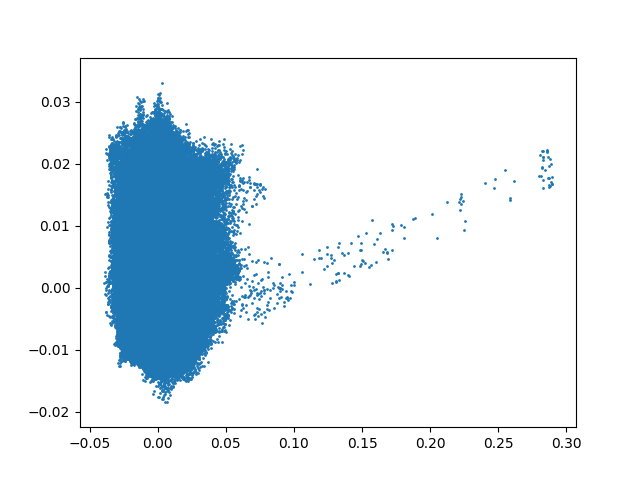

In [18]:
plt.scatter(pixels_pca[:,0], pixels_pca[:,1], s=1)
plt.show()

In [359]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering

In [67]:
from sklearn.manifold import Isomap, SpectralEmbedding, TSNE

In [35]:
embedding = TSNE(n_components=2)

In [38]:
embedded_pixels = embedding.fit_transform(list(pixels.values())[:10000])

<IPython.core.display.Javascript object>


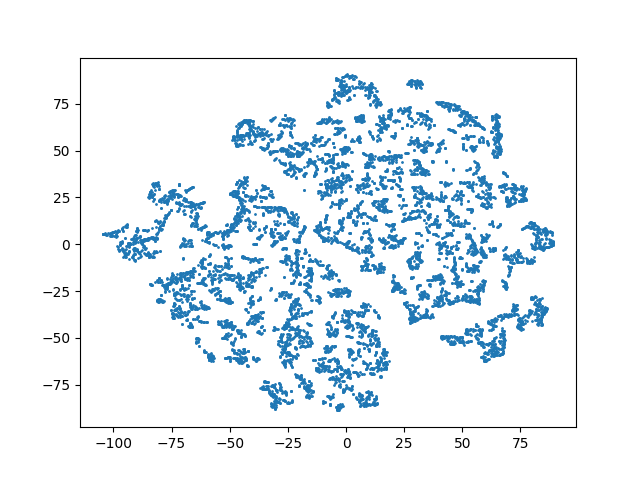

In [39]:
plt.scatter(embedded_pixels[:,0], embedded_pixels[:,1], s=1)
plt.show()

In [ ]:
clustering = D(n_clusters=5)
clusters = clustering.fit_predict(list(pixels.values()))

In [361]:
result_raster = np.zeros(image.shape[1:], dtype='uint8')

In [362]:
for (i,j), c in zip(pixels.keys(), clusters):
    result_raster[i,j] = c+1

<IPython.core.display.Javascript object>


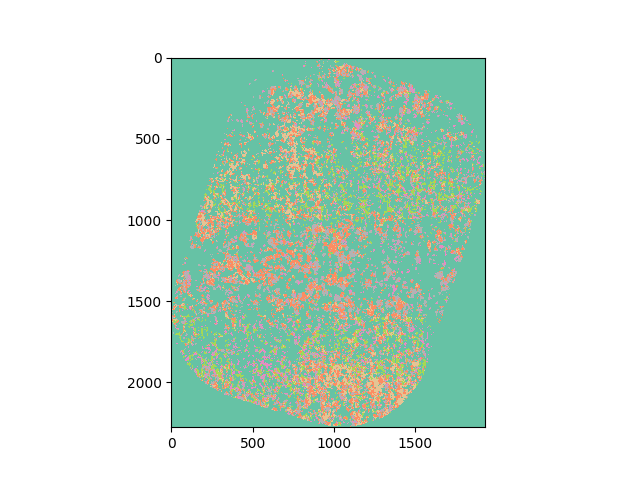

In [363]:
plt.imshow(result_raster, cmap='Set2')
plt.show()

In [128]:
from scripts.thresholding_watershed import itcd as itcd_tw

In [126]:
delineation_image = image[0]
delineation_image *= mask

In [129]:
polys = itcd_tw(delineation_image, smoothing=1, min_distance=10, thres_coef=1)

In [130]:
np.max(polys)

2703

<IPython.core.display.Javascript object>


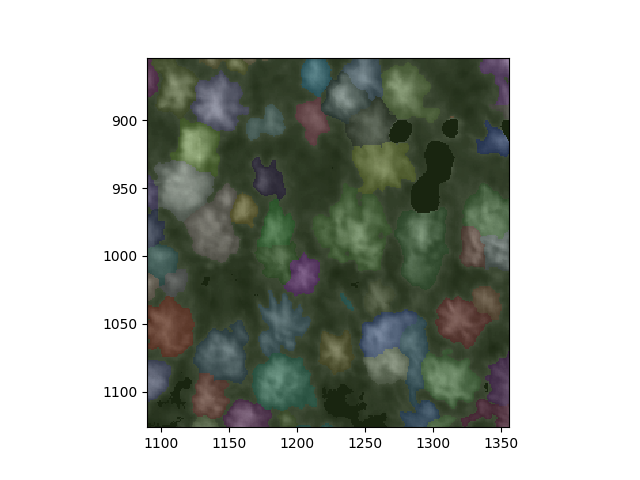

In [470]:
cmap = clr.ListedColormap(np.random.rand(16000,3))

plt.imshow(delineation_image, cmap='gray')
plt.imshow(polys, cmap=cmap, alpha=0.2)
plt.show()

In [131]:
trees_polys = [np.where(polys==i) for i in range(1,np.max(polys)+1)]

<IPython.core.display.Javascript object>


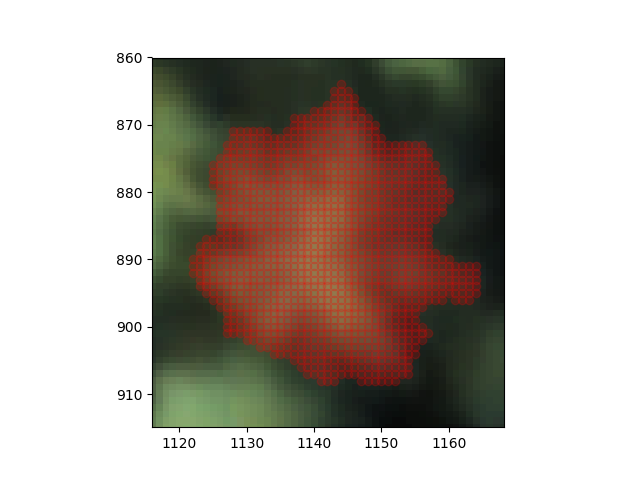

In [472]:
tree_id = 1000

plt.imshow(display_image_original)
plt.scatter(trees_polys[tree_id][1], trees_polys[tree_id][0], alpha=0.2, c='r')
plt.show()

<IPython.core.display.Javascript object>


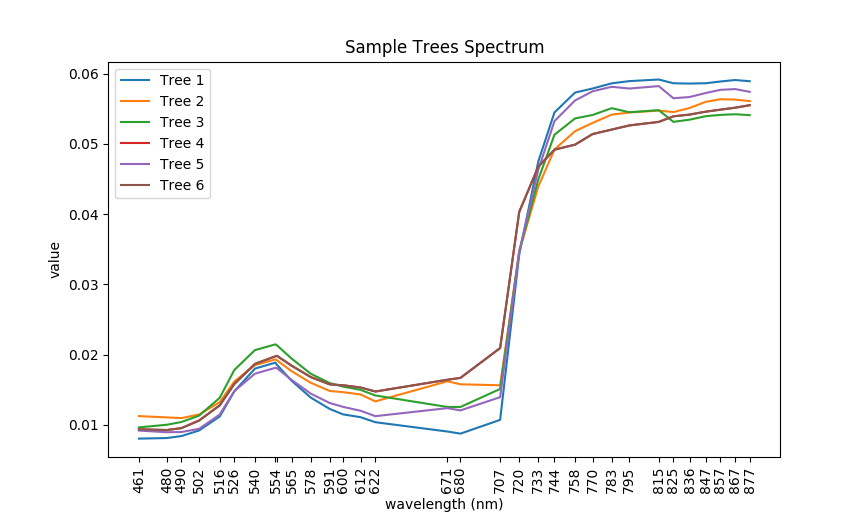

In [473]:
plt.plot(BANDS, np.nanmean(normalized[:,trees_polys[33][0],trees_polys[33][1]],axis=1), label='Tree 1')
plt.plot(BANDS, np.nanmean(normalized[:,trees_polys[226][0],trees_polys[226][1]],axis=1), label='Tree 2')
plt.plot(BANDS, np.nanmean(normalized[:,trees_polys[133][0],trees_polys[133][1]],axis=1), label='Tree 3')
plt.plot(BANDS, np.nanmean(normalized[:,trees_polys[26][0],trees_polys[26][1]],axis=1), label='Tree 4')
plt.plot(BANDS, np.nanmean(normalized[:,trees_polys[67][0],trees_polys[67][1]],axis=1), label='Tree 5')
plt.plot(BANDS, np.nanmean(normalized[:,trees_polys[26][0],trees_polys[26][1]],axis=1), label='Tree 6')
plt.xticks(BANDS, labels=BANDS_L, rotation='vertical')
plt.legend()
plt.xlabel('wavelength (nm)')
plt.ylabel('value')
plt.title('Sample Trees Spectrum')
plt.show()

In [132]:
mean_spectra = [np.nanmean(normalized[:,trees_polys[i][0],trees_polys[i][1]],axis=1) for i in range(np.max(polys))]

In [479]:
embedding = SpectralEmbedding(n_components=2)

In [480]:
embedded_features = embedding.fit_transform(mean_spectra)

<IPython.core.display.Javascript object>


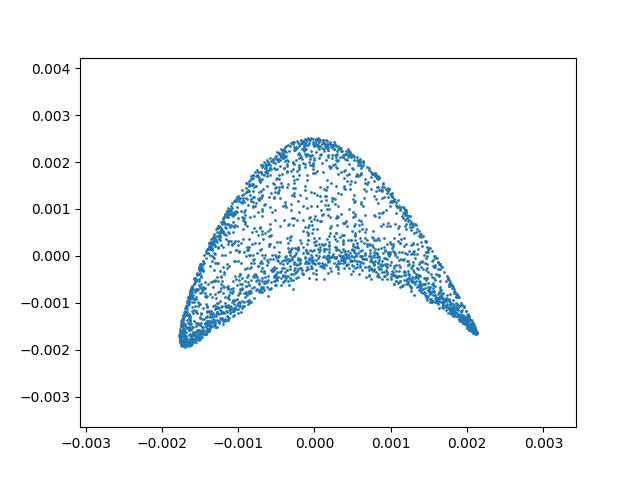

In [481]:
plt.scatter(embedded_features[:,0], embedded_features[:,1], s=1)
plt.show()

In [133]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering, AffinityPropagation
from sklearn.metrics.cluster import silhouette_score

from scripts.to_shapefile import crowns_segments

In [198]:
clustering = KMeans(n_clusters=3)
clusters = clustering.fit_predict(mean_spectra)

print(silhouette_score(mean_spectra, clusters))

0.3034228552315897


In [199]:
attr_hyper = {'cluster': ('int', [int(c) for c in clusters])}

In [200]:
crowns_segments('./test_shape/shape_11', polys, src, attr=attr_hyper)

In [3]:
import fiona
from shapely import geometry

from collections import Counter

from scipy.stats import pearsonr

In [201]:
grid = fiona.open("../data/pp_2/pp_2_grid_32/", "r")
shapefile = fiona.open("../data/pp_2/pp_2_trees/", "r")
results = fiona.open("./test_shape/shape_11/", "r")

In [86]:
def shapefile_statistics(shapefile, grid, dbh_thrs=0):
    shapefile_stats = {}

    for gk in grid.keys():
        cell = geometry.shape(grid[gk]['geometry'])
        cur_trees = []
        for sk in shapefile.keys():
            point = shapely.geometry.shape(shapefile[sk]['geometry'])
            if shapefile[sk]['properties']['add_class']==None:
                if shapefile[sk]['properties']['d'] > dbh_thrs:
                    if point.within(cell):
                        cur_trees.append(shapefile[sk]['properties']['specie'])
        shapefile_stats[grid[gk]['properties']['id']] = cur_trees
        
    shannons_shapefile = {}
    richness_shapefile = {}
    simpsons_shapefile = {}

    for i in shapefile_stats:
        richness_shapefile[i] = len(set(shapefile_stats[i]))
        cur_simpsons = Counter(shapefile_stats[i]).values()
        total_number = sum(cur_simpsons)
        simpsons_shapefile[i] = 1 - sum([(j*(j-1))/(total_number*(total_number-1)) for j in cur_simpsons])
        cur_shannons = Counter(shapefile_stats[i]).values()
        cur_shannons = [j/sum(cur_shannons) for j in cur_shannons]
        cur_shannons = -sum([j*np.log2(j) for j in cur_shannons])
        shannons_shapefile[i] = cur_shannons
    
    return richness_shapefile, simpsons_shapefile, shannons_shapefile

In [90]:
def results_statistics(results, grid):
    results_stats = {}

    for gk in grid.keys():
        cell = shapely.geometry.shape(grid[gk]['geometry'])
        cur_trees = []
        for rk in results.keys():
            polygon = geometry.shape(results[rk]['geometry'])
            if polygon.centroid.within(cell):
                cur_trees.append(results[rk]['properties']['cluster'])
        results_stats[grid[gk]['properties']['id']] = cur_trees
        
    shannons_results = {}
    richness_results = {}
    simpsons_results = {}

    for i in results_stats:
        richness_results[i] = len(set(results_stats[i]))
        cur_simpsons = Counter(results_stats[i]).values()
        total_number = sum(cur_simpsons)
        simpsons_results[i] = 1 - sum([(j*(j-1))/(total_number*(total_number-1)) for j in cur_simpsons])
        cur_shannons = Counter(results_stats[i]).values()
        cur_shannons = [j/sum(cur_shannons) for j in cur_shannons]
        cur_shannons = -sum([j*np.log2(j) for j in cur_shannons])
        shannons_results[i] = cur_shannons
    
    return richness_results, simpsons_results, shannons_results

In [202]:
richness_shapefile, simpsons_shapefile, shannons_shapefile = shapefile_statistics(shapefile, grid, dbh_thrs=15)

In [203]:
richness_results, simpsons_results, shannons_results = results_statistics(results, grid)

In [204]:
print(pearsonr(list(richness_shapefile.values()), list(richness_results.values())))
print(pearsonr(list(shannons_shapefile.values()), list(shannons_results.values())))
print(pearsonr(list(simpsons_shapefile.values()), list(simpsons_results.values())))

(0.23753740502422435, 0.19050617460933608)
(0.22532892150054507, 0.21498983598239918)
(0.24636768759833783, 0.17405858540498162)


In [170]:
from tqdm import tqdm_notebook

In [227]:
simpsons_correlation = []
shannons_correlation = []
r = range(6,28)
for dbh in tqdm_notebook(r):
    richness_shapefile, simpsons_shapefile, shannons_shapefile = shapefile_statistics(shapefile, grid, dbh_thrs=dbh)
    simpsons_correlation.append(pearsonr(list(simpsons_shapefile.values()), list(simpsons_results.values()))[0])
    shannons_correlation.append(pearsonr(list(shannons_shapefile.values()), list(shannons_results.values()))[0])

ZeroDivisionError: division by zero

In [207]:
z_1 = np.poly1d(np.polyfit(r,np.array(simpsons_correlation)*2,2))
z_2 = np.poly1d(np.polyfit(r,np.array(shannons_correlation)*2,2))

<IPython.core.display.Javascript object>


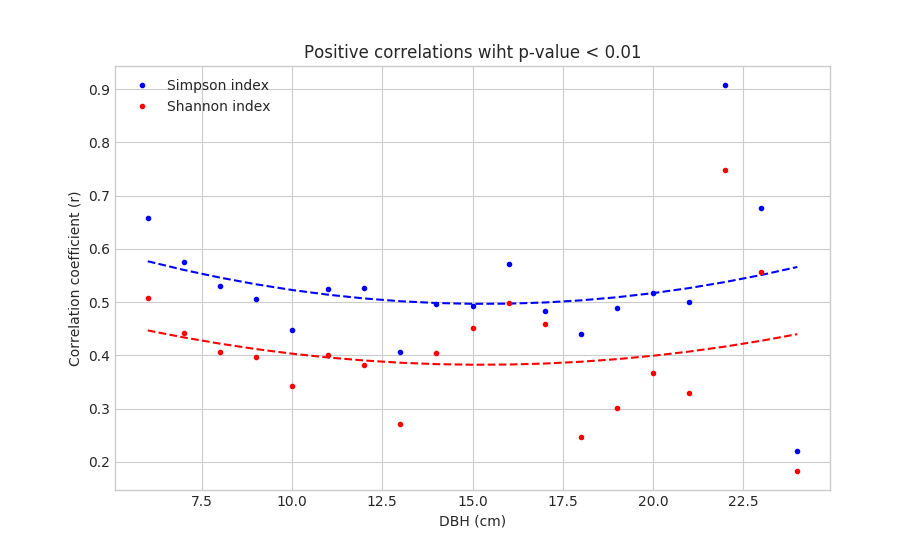

In [226]:
plt.plot(r, [z_1(i) for i in r], '--', c='b')
plt.plot(r, np.array(simpsons_correlation)*2, '.', c='b', label='Simpson index')
plt.plot(r, [z_2(i) for i in r], '--', c='r')
plt.plot(r, np.array(shannons_correlation)*2, '.', c='r', label='Shannon index')
plt.legend()
plt.xlabel('DBH (cm)')
plt.ylabel('Correlation coefficient (r)')
plt.title('Positive correlations wiht p-value < 0.01')
plt.show()

# Supervised Classification

In [4]:
import fiona
import scipy
from shapely import geometry
from rasterio.mask import mask

In [242]:
hsi_pp_1 = rasterio.open("../data/pp_1/pp_1_hsi_clipped.tif")
hsi_pp_2 = rasterio.open("../data/pp_2/pp_2_hsi_clipped.tif")
hsi_pp_3 = rasterio.open("../data/pp_3/pp_3_hsi_clipped.tif")
hsi_pp_4 = rasterio.open("../data/pp_4/pp_4_hsi_clipped.tif")

chm_pp_1 = rasterio.open("../data/pp_1/pp_1_chm.tif")
chm_pp_2 = rasterio.open("../data/pp_2/pp_2_chm.tif")
chm_pp_3 = rasterio.open("../data/pp_3/pp_3_chm.tif")
chm_pp_4 = rasterio.open("../data/pp_4/pp_4_chm.tif")

trees_pp_2 = fiona.open("../data/pp_2/pp_2_trees_h/", "r")
trees_pp_3 = fiona.open("../data/pp_3/pp_3_trees_h/", "r")
trees_pp_4 = fiona.open("../data/pp_4/pp_4_trees_h/", "r")

In [6]:
def exclude_bad_pixels(image_instance):
    bad_pixels = np.where(image_instance[-1]==0)
    mask = (np.repeat(range(32), bad_pixels[0].shape[0]), 
            np.tile(bad_pixels[0], 32), 
            np.tile(bad_pixels[1], 32))
    image_instance[mask] = np.ma.masked
    

def get_trees(hsi_pp, chm_pp, trees_pp, hsi_radius=1.0, chm_radius=1.0):
    hsi_images, chm_images, labels, ids = [], [], [], []
    map_tree_speices = {'е':0, 'б':1, 'п':2, "El'":0, "Bereza":1, "Pichta":2, "Sosna":3} 
    
    for tree in trees_pp.values():
        tree_specie = tree['properties']['specie']
        labels.append(map_tree_speices[tree_specie])
        ids.append(tree['properties']['id_tree'])
        
        geometry_hsi = geometry.shape(tree['geometry']).buffer(hsi_radius)
        geometry_chm = geometry.shape(tree['geometry']).buffer(chm_radius)
        
        hsi_image, _ = mask(hsi_pp, [geometry_hsi], filled=False, crop=True)
        chm_image, _ = mask(chm_pp, [geometry_chm], filled=False, crop=True)
        
        exclude_bad_pixels(hsi_image)
        hsi_images.append(hsi_image/65535)
        chm_images.append(chm_image)
    
    return hsi_images, labels, chm_images, ids

In [483]:
RADIUS_HSI = 0.5
RADIUS_CHM = 2.0

tree_images_pp_2, tree_labels_pp_2, tree_chms_pp_2, tree_ids_pp_2 = get_trees(hsi_pp_2, chm_pp_2, trees_pp_2,
                                                                              hsi_radius=RADIUS_HSI, 
                                                                              chm_radius=RADIUS_CHM)
tree_images_pp_3, tree_labels_pp_3, tree_chms_pp_3, tree_ids_pp_3 = get_trees(hsi_pp_3, chm_pp_3, trees_pp_3,
                                                                              hsi_radius=RADIUS_HSI, 
                                                                              chm_radius=RADIUS_CHM)
tree_images_pp_4, tree_labels_pp_4, tree_chms_pp_4, tree_ids_pp_4 = get_trees(hsi_pp_4, chm_pp_4, trees_pp_4,
                                                                              hsi_radius=RADIUS_HSI, 
                                                                              chm_radius=RADIUS_CHM)

In [484]:
tree_labels_pp_2 = np.array(tree_labels_pp_2)
tree_labels_pp_3 = np.array(tree_labels_pp_3)
tree_labels_pp_4 = np.array(tree_labels_pp_4)

tree_ids_pp_2 = np.array(tree_ids_pp_2)
tree_ids_pp_3 = np.array(tree_ids_pp_3)
tree_ids_pp_4 = np.array(tree_ids_pp_4)

<IPython.core.display.Javascript object>


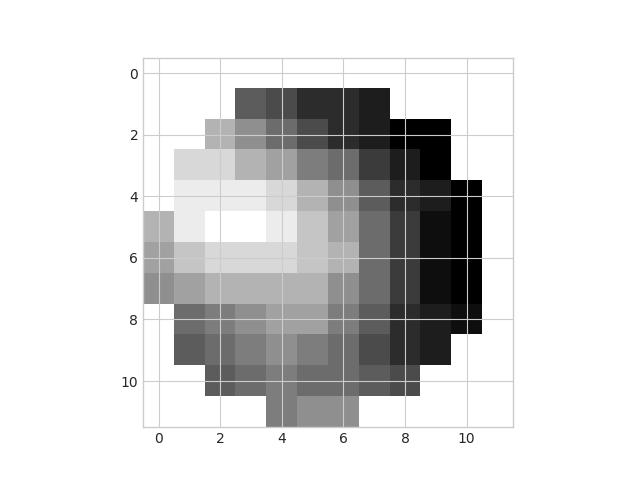

In [485]:
plt.imshow(tree_images_pp_2[20][0], cmap='gray')
plt.show()

### Features Calculation

In [10]:
def calculate_features(trees_images):
    mean_spectras, median_spectras = [], []
    mean_spectras_norm, median_spectras_norm = [], []
    
    for tree_image in trees_images:
        mean_spectra = [np.ma.mean(band) for band in tree_image]
        median_spectra = [np.ma.median(band) for band in tree_image]
        
        tree_image = tree_image/np.ma.sum(tree_image,axis=0)
        
        mean_spectra_norm = [np.ma.mean(band) for band in tree_image]
        median_spectra_norm = [np.ma.median(band) for band in tree_image]
        
        mean_spectras.append(mean_spectra)
        median_spectras.append(median_spectra)
        
        mean_spectras_norm.append(mean_spectra_norm)
        median_spectras_norm.append(median_spectra_norm)
    
    return (np.array(mean_spectras), np.array(median_spectras),
            np.array(mean_spectras_norm), np.array(median_spectras_norm))

In [155]:
def mean_spectra(hsi_images, normalized=False):
    features = []
    for hsi_image in hsi_images:
        if normalized:
            hsi_image = hsi_image/np.ma.sum(hsi_image,axis=0)
        feature_vector = [np.ma.mean(band) for band in hsi_image]
        features.append(feature_vector)
    return np.array(features)


def median_spectra(hsi_images, normalized=False):
    features = []
    for hsi_image in hsi_images:
        if normalized:
            hsi_image = hsi_image/np.ma.sum(hsi_image,axis=0)
        feature_vector = [np.ma.median(band) for band in hsi_image]
        features.append(feature_vector)
    return np.array(features)


def structural_features(chm_images):
    features = []
    for chm_image in chm_images:
        feature_vector = [np.ma.mean(chm_image)/np.ma.max(chm_image),
                          np.ma.min(chm_image)/np.ma.max(chm_image),
                          np.ma.std(chm_image)/np.ma.max(chm_image),
                          scipy.stats.skew(chm_image[~chm_image.mask]),
                          scipy.stats.skew(chm_image[~chm_image.mask])]
        features.append(feature_vector)
    return np.array(features)

In [486]:
(mean_spectra_pp_2, median_spectra_pp_2,
 mean_spectra_norm_pp_2, median_spectra_norm_pp_2) = calculate_features(tree_images_pp_2)

(mean_spectra_pp_3, median_spectra_pp_3,
 mean_spectra_norm_pp_3, median_spectra_norm_pp_3) = calculate_features(tree_images_pp_3)

(mean_spectra_pp_4, median_spectra_pp_4,
 mean_spectra_norm_pp_4, median_spectra_norm_pp_4) = calculate_features(tree_images_pp_4)

In [172]:
tree_features_pp_2 = np.hstack((mean_spectra_norm_pp_2, median_spectra_norm_pp_2))
tree_features_pp_3 = np.hstack((mean_spectra_norm_pp_3, median_spectra_norm_pp_3))
tree_features_pp_4 = np.hstack((mean_spectra_norm_pp_4, median_spectra_norm_pp_4))

tree_features = np.concatenate((tree_features_pp_2, tree_features_pp_3, tree_features_pp_4))
tree_labels = np.concatenate((tree_labels_pp_2, tree_labels_pp_3, tree_labels_pp_4))

In [487]:
tree_features = np.concatenate((mean_spectra_norm_pp_2, mean_spectra_norm_pp_3, mean_spectra_norm_pp_4))
tree_labels = np.concatenate((tree_labels_pp_2, tree_labels_pp_3, tree_labels_pp_4))

In [158]:
TREE_COLORS = {0:'g',1:'b',2:'r',3:'y'}

In [15]:
mean_spruce_pp_2 = np.mean(mean_spectra_norm_pp_2[np.where(tree_labels_pp_2==0)], axis=0)
mean_spruce_pp_3 = np.mean(mean_spectra_norm_pp_3[np.where(tree_labels_pp_3==0)], axis=0)
mean_spruce_pp_4 = np.mean(mean_spectra_norm_pp_4[np.where(tree_labels_pp_4==0)], axis=0)

mean_birch_pp_2 = np.mean(mean_spectra_norm_pp_2[np.where(tree_labels_pp_2==1)], axis=0)
mean_birch_pp_3 = np.mean(mean_spectra_norm_pp_3[np.where(tree_labels_pp_3==1)], axis=0)
mean_birch_pp_4 = np.mean(mean_spectra_norm_pp_4[np.where(tree_labels_pp_4==1)], axis=0)

mean_pine_pp_3 = np.mean(mean_spectra_norm_pp_3[np.where(tree_labels_pp_3==3)], axis=0)

<IPython.core.display.Javascript object>


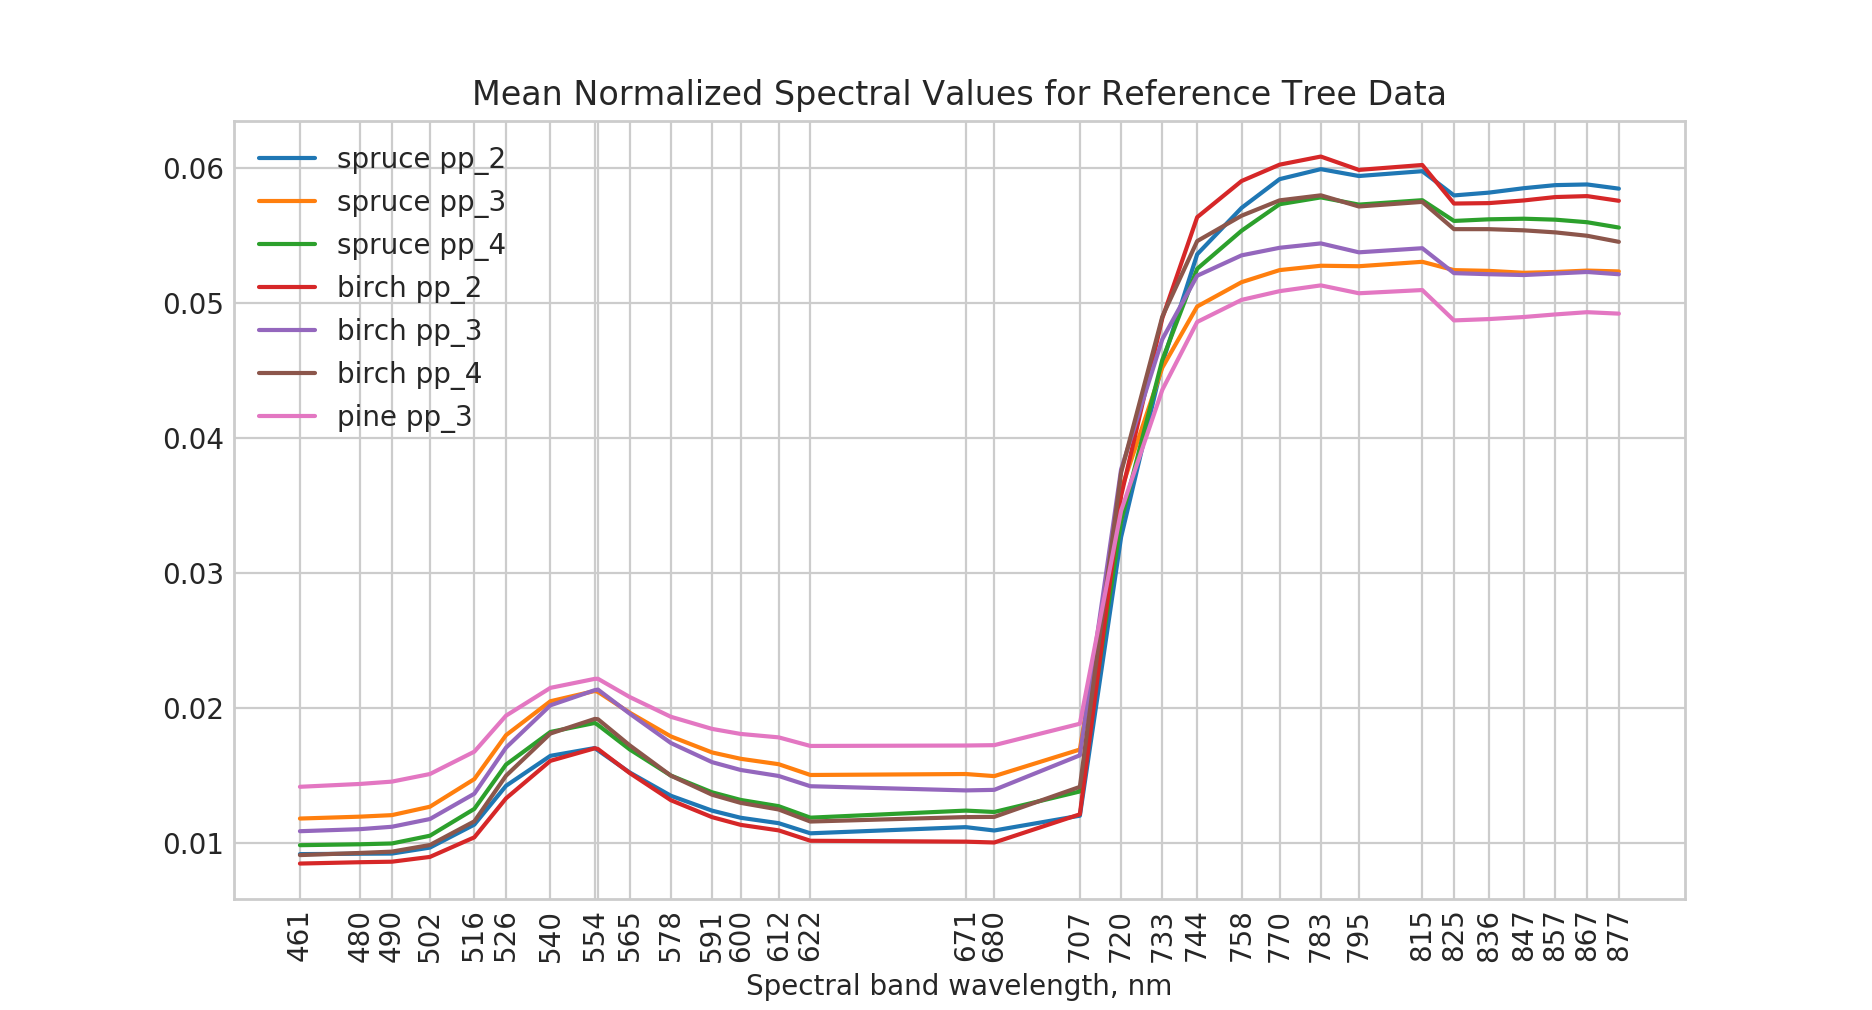

In [17]:
plt.plot(BANDS, mean_spruce_pp_2, label='spruce pp_2')
plt.plot(BANDS, mean_spruce_pp_3, label='spruce pp_3')
plt.plot(BANDS, mean_spruce_pp_4, label='spruce pp_4')
plt.plot(BANDS, mean_birch_pp_2, label='birch pp_2')
plt.plot(BANDS, mean_birch_pp_3, label='birch pp_3')
plt.plot(BANDS, mean_birch_pp_4, label='birch pp_4')
plt.plot(BANDS, mean_pine_pp_3, label='pine pp_3')
plt.legend()    
plt.xticks(BANDS, labels=BANDS_L, rotation='vertical')
plt.xlabel('Spectral band wavelength, nm')
plt.title('Mean Normalized Spectral Values for Reference Tree Data')
plt.show()

<IPython.core.display.Javascript object>


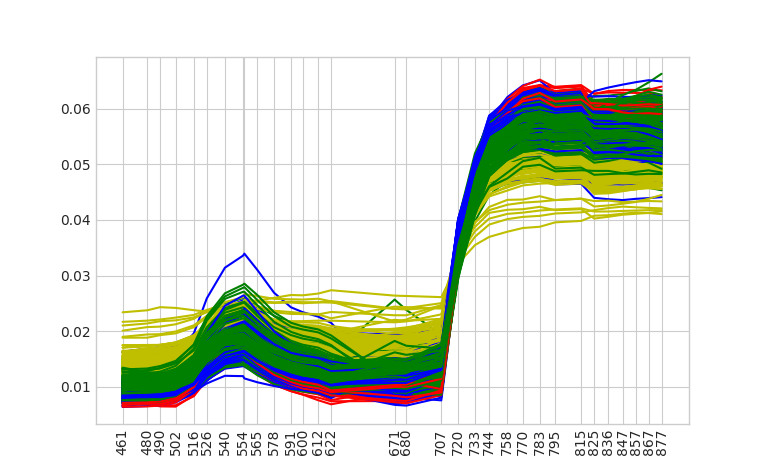

In [168]:
for i in range(len(tree_features)):
    plt.plot(BANDS, tree_features[i], c=TREE_COLORS[tree_labels[i]])
    
plt.xticks(BANDS, labels=BANDS_L, rotation='vertical')
plt.show()

In [88]:
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, f1_score
from sklearn.feature_selection import RFE, RFECV

### LOO Cross Validation

In [67]:
rfc = RandomForestClassifier(n_estimators=200)
knn = KNeighborsClassifier(n_neighbors=3)
svm_rbf = SVC(C=1000, kernel='rbf', gamma='scale')
svm_linear = SVC(C=1000, kernel='linear', gamma='scale')

In [456]:
y_preds, y_trues = [], []

loo = LeaveOneOut()

for train_index, test_index in tqdm_notebook(loo.split(tree_features), total=len(tree_features)):
    X_train, X_test = tree_features[train_index], tree_features[test_index]
    y_train, y_test = tree_labels[train_index], tree_labels[test_index]
    
    clf = svm_rbf
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    y_preds.append(y_pred[0])
    y_trues.append(y_test[0])

y_trues = np.array(y_trues)
y_preds = np.array(y_preds)

In [457]:
f1_score(y_trues, y_preds, average='macro')

/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6997658786687464

In [458]:
accuracy_score(y_trues, y_preds)

0.9063097514340345

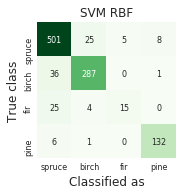

In [279]:
plt.figure(figsize=(2.5,2.5))
g = sns.heatmap([np.bincount(y_preds[np.where(y_trues==i)], minlength=4) for i in range(4)],
                annot=True, cbar=False, fmt='d', cmap='Greens', annot_kws={"size":8})
g.set_xticklabels(['spruce','birch','fir','pine'], rotation=0, fontsize=8)
g.set_yticklabels(['spruce','birch','fir','pine'], rotation=90, fontsize=8)
plt.xlabel('Classified as', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.title('SVM RBF')
plt.show()

### K-Fold Cross Validation

In [51]:
clf = RandomForestClassifier(n_estimators=200)
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='f1_micro', cv=10)
print(np.mean(cv_scores), np.std(cv_scores))

0.8802904180540141 0.054519447400526166


In [56]:
clf = KNeighborsClassifier(n_neighbors=3)
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='accuracy', cv=10)
print(np.mean(cv_scores), np.std(cv_scores))

0.8612417826346794 0.059397991212400074


In [317]:
clf = GaussianNB(var_smoothing=3.111)
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='accuracy', cv=40)
print(np.mean(cv_scores), np.std(cv_scores))

0.7498352490421456 0.12411254305636908


In [252]:
clf = MLPClassifier(max_iter=3000)
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='accuracy', cv=3)
print(np.mean(cv_scores), np.std(cv_scores))

0.8231028762214612 0.06690717199462673


In [53]:
clf = SVC(C=1000, kernel='rbf', gamma='scale')
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='f1_micro', cv=10)
print(np.mean(cv_scores), np.std(cv_scores))

0.8880930020774638 0.04305163234384253


In [54]:
clf = SVC(C=1000, kernel='linear')
cv_scores = cross_val_score(clf, tree_features, tree_labels, scoring='f1_micro', cv=10)
print(np.mean(cv_scores), np.std(cv_scores))

0.8688608099262927 0.05935501563773575


### UpSample Firs

In [290]:
from sklearn.utils import resample

In [414]:
UPSAMPLE = 100

In [488]:
tree_features_upsampled = np.delete(tree_features, np.where(tree_labels==2), axis=0)
tree_labels_upsampled = np.delete(tree_labels, np.where(tree_labels==2), axis=0)

In [489]:
fir_upsampled = resample(tree_features[np.where(tree_labels==2)], replace=True, n_samples=UPSAMPLE, random_state=26)

In [490]:
tree_features_upsampled = np.concatenate((tree_features_upsampled, fir_upsampled))
tree_labels_upsampled = np.concatenate((tree_labels_upsampled, np.repeat(2,UPSAMPLE)))

In [220]:
clf = RandomForestClassifier(n_estimators=200)
cv_scores = cross_val_score(clf, tree_features_upsampled, tree_labels_upsampled, scoring='accuracy', cv=10)
print(np.mean(cv_scores), np.std(cv_scores))

0.9056069706069707 0.04658630052619169


In [491]:
y_preds, y_trues = [], []

loo = LeaveOneOut()

for train_index, test_index in tqdm_notebook(loo.split(tree_features_upsampled), total=len(tree_features_upsampled)):
    X_train, X_test = tree_features_upsampled[train_index], tree_features_upsampled[test_index]
    y_train, y_test = tree_labels_upsampled[train_index], tree_labels_upsampled[test_index]
    
    clf = rfc
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    y_preds.append(y_pred[0])
    y_trues.append(y_test[0])

y_trues = np.array(y_trues)
y_preds = np.array(y_preds)

In [492]:
f1_score(y_trues, y_preds, average='macro')

0.9255141610653322

In [493]:
accuracy_score(y_trues, y_preds)

0.9183303085299456

<IPython.core.display.Javascript object>


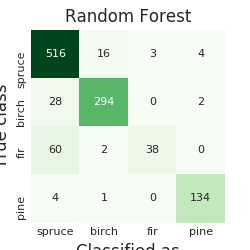

In [468]:
plt.figure(figsize=(2.5,2.5))
g = sns.heatmap([np.bincount(y_preds[np.where(y_trues==i)], minlength=4) for i in range(4)],
                annot=True, cbar=False, fmt='d', cmap='Greens', annot_kws={"size":8})
g.set_xticklabels(['spruce','birch','fir','pine'], rotation=0, fontsize=8)
g.set_yticklabels(['spruce','birch','fir','pine'], rotation=90, fontsize=8)
plt.xlabel('Classified as', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.title('Random Forest')
plt.show()

### Feature Selection

In [300]:
estimator = RandomForestClassifier(n_estimators=200)
selector = RFECV(estimator, step=1, cv=10, scoring='accuracy')

In [298]:
feature_importances = []

for i in tqdm_notebook(range(1)):
    estimator = RandomForestClassifier(n_estimators=200)
    estimator.fit(tree_features_upsampled, tree_labels_upsampled)
    feature_importances.append(estimator.feature_importances_)

In [446]:
np.argsort(np.mean(feature_importances, axis=0))[::-1]

array([19, 18, 20,  3,  2,  4, 28, 27, 26,  1, 29, 16, 21, 30, 15, 31,  0,
        5, 17, 14, 13, 22, 23,  7,  8, 12,  6, 24, 25,  9, 11, 10])

In [450]:
estimator = RandomForestClassifier(n_estimators=1000)
selector = RFE(estimator=estimator, n_features_to_select=1, step=1)

In [301]:
selector = selector.fit(tree_features_upsampled, tree_labels_upsampled)

<IPython.core.display.Javascript object>


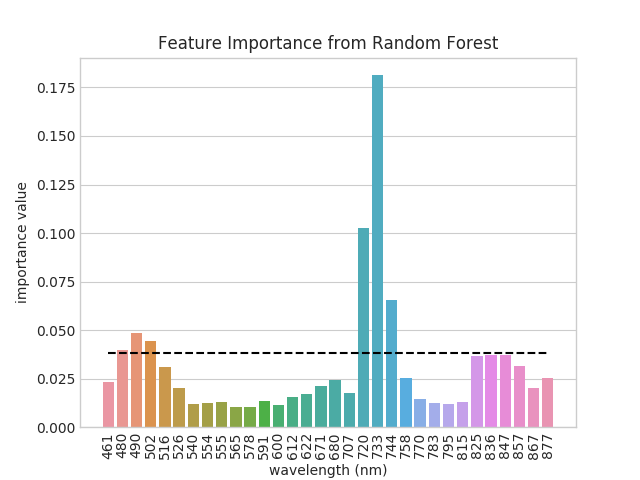

In [409]:
g = sns.barplot(BANDS, np.mean(feature_importances, axis=0))
g.set_xticklabels(BANDS, rotation=90)
g.set_xlabel('wavelength (nm)')
g.set_ylabel('importance value')
g.set_title('Feature Importance from Random Forest')
plt.plot([0.038]*32, '--', c='k')
plt.show()

<IPython.core.display.Javascript object>


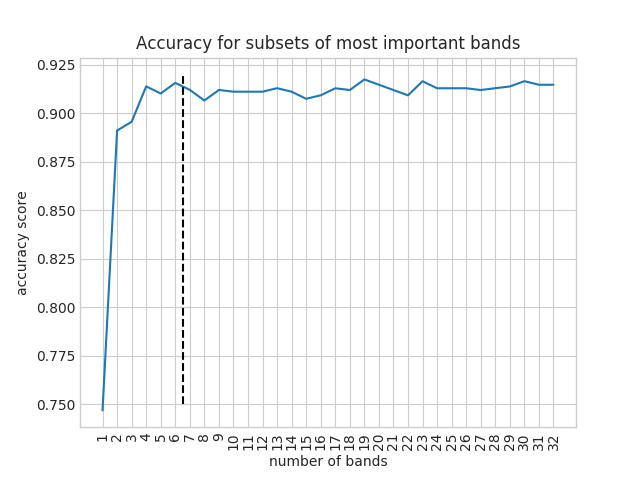

In [408]:
plt.plot(range(1,33), selector.grid_scores_+0.01)
plt.xticks(range(1,33), range(1,33), rotation='vertical')
plt.xlabel('number of bands')
plt.ylabel('accuracy score')
plt.title('Accuracy for subsets of most important bands')
plt.plot([6.5]*18, np.arange(0.75,0.92,0.01), '--', c='k')
plt.show()

In [425]:
np.argsort(selector.ranking_)

array([19,  3, 26, 20, 18,  2, 27,  1, 28,  4, 21, 29, 16, 17, 30,  0, 14,
        5, 22, 31, 15,  7, 13,  8, 23, 12,  6, 25,  9, 24, 11, 10])

In [221]:
clf = RandomForestClassifier(n_estimators=200)
clf.fit(tree_features_upsampled, tree_labels_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Pixel Based Approach

In [28]:
pixels_features_pp_2, pixels_labels_pp_2 = [], []
pixels_features_pp_3, pixels_labels_pp_3 = [], []
pixels_features_pp_4, pixels_labels_pp_4 = [], []

for i in range(len(tree_ids_pp_2)):
    tree_image = tree_images_pp_2[i]
    tree_image = tree_image/np.ma.sum(tree_image,axis=0)
    tree_image = tree_image.reshape(32,tree_image.shape[1]*tree_image.shape[2])
    tree_image = np.swapaxes(tree_image, 0, 1)
    pixel_features = np.array([pixel.data for pixel in tree_image if not pixel.mask.any()])
    pixels_features_pp_2.append(pixel_features)
    pixels_labels_pp_2.append(np.repeat(tree_labels_pp_2[i],len(pixel_features)))
    
for i in range(len(tree_ids_pp_3)):
    tree_image = tree_images_pp_3[i]
    tree_image = tree_image/np.ma.sum(tree_image,axis=0)
    tree_image = tree_image.reshape(32,tree_image.shape[1]*tree_image.shape[2])
    tree_image = np.swapaxes(tree_image, 0, 1)
    pixel_features = np.array([pixel.data for pixel in tree_image if not pixel.mask.any()])
    pixels_features_pp_3.append(pixel_features)
    pixels_labels_pp_3.append(np.repeat(tree_labels_pp_3[i],len(pixel_features)))
    
for i in range(len(tree_ids_pp_4)):
    tree_image = tree_images_pp_4[i]
    tree_image = tree_image/np.ma.sum(tree_image,axis=0)
    tree_image = tree_image.reshape(32,tree_image.shape[1]*tree_image.shape[2])
    tree_image = np.swapaxes(tree_image, 0, 1)
    pixel_features = np.array([pixel.data for pixel in tree_image if not pixel.mask.any()])
    pixels_features_pp_4.append(pixel_features)
    pixels_labels_pp_4.append(np.repeat(tree_labels_pp_4[i],len(pixel_features)))

In [29]:
pixels_features_pp_2 = np.array(pixels_features_pp_2)
pixels_features_pp_3 = np.array(pixels_features_pp_3)
pixels_features_pp_4 = np.array(pixels_features_pp_4)

In [30]:
pixels_labels_pp_2 = np.array(pixels_labels_pp_2)
pixels_labels_pp_3 = np.array(pixels_labels_pp_3)
pixels_labels_pp_4 = np.array(pixels_labels_pp_4)

In [31]:
pixels_features = np.concatenate((pixels_features_pp_2, pixels_features_pp_3, pixels_features_pp_4))
pixels_labels = np.concatenate((pixels_labels_pp_2, pixels_labels_pp_3, pixels_labels_pp_4))

In [34]:
scores = []
preds = {0:[],1:[],2:[],3:[]}

cv = KFold(n_splits=10)

for train_index, test_index in tqdm_notebook(cv.split(pixels_features), total=cv.n_splits):
    X_train, X_test = pixels_features[train_index], pixels_features[test_index]
    y_train, y_test = pixels_labels[train_index], pixels_labels[test_index]
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(np.concatenate(X_train), np.concatenate(y_train))
    for i in range(len(y_test)):
        pixels_preds = clf.predict(X_test[i])
        y_pred = np.argmax(np.bincount(pixels_preds))
        y_true = set(y_test[i]).pop()
        scores.append(accuracy_score([y_true], [y_pred]))
    
print(np.mean(scores))

0.9168260038240917


## Delineated Tree Crowns

In [194]:
from skimage.feature import peak_local_max
from skimage.filters import gaussian

/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


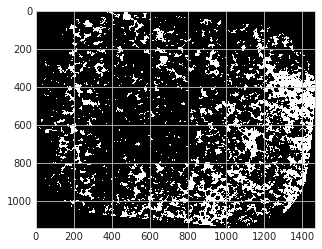

In [243]:
image = hsi_pp_1.read()
ndvi = (image[24]-image[15])/(image[24]+image[15])

ndvi_mask = np.zeros_like(image[0])    
ndvi_mask[np.where(ndvi<0.5)] = 1

plt.imshow(ndvi_mask, cmap='gray')
plt.show()

In [198]:
def tree_detection(input_layer_path, output_shapefile_path, smoothing=0, min_distance=3, mask=None):
    input_layer = rasterio.open(input_layer_path)
    input_raster = input_layer.read(1)
    if mask is not None:
        input_raster[np.where(mask)] = 0
    input_raster = gaussian(input_raster, sigma=smoothing)
    tree_tops = peak_local_max(input_raster, min_distance=min_distance, exclude_border=0, indices=True)
    
    schema = {'geometry': 'Point', 'properties': {'id': 'int'},}
    with fiona.open(output_shapefile_path, 'w', 'ESRI Shapefile', schema, input_layer.crs) as c:
        for i, tree_top in enumerate(tree_tops):
            tree_point = geometry.Point(input_layer.xy(tree_top[0], tree_top[1]))
            c.write({'geometry': geometry.mapping(tree_point), 'properties': {'id': i},})

In [199]:
def evaluate_detection(labeled_trees_path, detected_trees_path, circle_radius=1):    
    labeled_trees = fiona.open(labeled_trees_path, "r")
    detected_trees = fiona.open(detected_trees_path, "r")
    
    detections = []

    for tree in tqdm_notebook(labeled_trees.values(), total=len(labeled_trees)):
        trees_detected = 0
        tree_circle = geometry.shape(tree['geometry']).buffer(circle_radius)
        for detected_tree in detected_trees.values():
            tree_top = geometry.shape(detected_tree['geometry'])
            if tree_top.within(tree_circle):
                trees_detected += 1
        detections.append(trees_detected)
    
    return detections.count(1)/len(labeled_trees)

In [373]:
tree_detection('../data/pp_4/pp_4_chm.tif', '/Users/vasilii.mosin/Desktop/test_shapes/test_shape_01',
              smoothing=0.4, min_distance=3, mask=None)

In [374]:
len(fiona.open('/Users/vasilii.mosin/Desktop/test_shapes/test_shape_01'))

1627

In [375]:
evaluate_detection('../data/pp_4/pp_4_trees_h', '/Users/vasilii.mosin/Desktop/test_shapes/test_shape_01',
                   circle_radius=1.5)

0.7675840978593272

# Final Prediction

In [222]:
def classify_detected_trees(hsi_path, detected_trees_path, output_shapefile_path, clf):
    hsi = rasterio.open(hsi_path)
    detected_trees = fiona.open(detected_trees_path, 'r')
    
    map_tree_speices = {0:'spruce', 1:'birch', 2:'fir', 3:'pine'}
    schema = {'geometry': 'Point', 'properties': {'id': 'int', 'specie': 'str', 'proba': 'float'},}
    
    with fiona.open(output_shapefile_path, 'w', 'ESRI Shapefile', schema, detected_trees.crs) as c:     

        for detected_tree in tqdm_notebook(detected_trees.values(), total=len(detected_trees)):
            tree_point = geometry.shape(detected_tree['geometry'])
            tree_geometry = geometry.shape(detected_tree['geometry']).buffer(1.0)
            tree_image, _ = mask(hsi, [tree_geometry], filled=False, crop=True)
            exclude_bad_pixels(tree_image)
            tree_image = tree_image/65535

            tree_image = tree_image/np.ma.sum(tree_image,axis=0)
            mean_spectra_norm = np.array([np.ma.mean(band) for band in tree_image])
            prediction_probas = clf.predict_proba(mean_spectra_norm.reshape(1,-1))[0]
            prediction_specie = np.argmax(prediction_probas)

            c.write({'geometry': geometry.mapping(tree_point), 
                     'properties': {'id': detected_tree['properties']['id'],
                                    'specie': map_tree_speices[prediction_specie],
                                    'proba': prediction_probas[prediction_specie]}})

In [246]:
classify_detected_trees('../data/pp_1/pp_1_hsi_clipped.tif', 
                        '/Users/vasilii.mosin/Desktop/test_shapes/test_shape_01',
                        '/Users/vasilii.mosin/Desktop/test_shapes/test_shape_04', clf)

In [247]:
classified_trees = fiona.open('/Users/vasilii.mosin/Desktop/test_shapes/test_shape_04', 'r')

classified_trees_statistics = {'spruce':[], 'birch':[], 'fir':[], 'pine':[]}

for classified_tree in classified_trees.values():
    properties = classified_tree['properties']
    classified_trees_statistics[properties['specie']].append(properties['proba'])
    
for specie in classified_trees_statistics:
    specie_stats = classified_trees_statistics[specie]
    print(specie, '\t', len(specie_stats), '\t', np.mean(specie_stats), '\t', np.std(specie_stats))

spruce 	 1275 	 0.7722549019607843 	 0.147619654775273
birch 	 297 	 0.8085858585858586 	 0.1601173397656328
fir 	 0 	 nan 	 nan
pine 	 218 	 0.6993577981651375 	 0.13992724341014845


/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/vasilii.mosin/.virtualenvs/forestry/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
